In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.metrics import Recall
from keras.metrics import Accuracy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('clean_sql_dataset - Copy.csv')

In [3]:
df.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149435 entries, 0 to 149434
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Query   149434 non-null  object
 1   Label   149435 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [5]:
df.dropna(inplace=True)

In [6]:
X=df['Query']
y=df['Label']

In [7]:
max_words = len(list(X.str.split(' ', expand=True).stack().unique()))
max_words

611692

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
max_words = 611692
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [10]:
from keras.models import Sequential
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1,activation="sigmoid"))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          61169200  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 61211505 (233.50 MB)
Trainable params: 61211505 (233.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



In [11]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history = model.fit(sequences_matrix,y_train, batch_size=128, epochs=10,
                   validation_split=0.2,callbacks=[callbacks])

Epoch 1/10


748/748 [==============================] - 393s 519ms/step - loss: 0.1005 - accuracy: 0.9699 - val_loss: 0.0484 - val_accuracy: 0.9886
Epoch 2/10
748/748 [==============================] - 381s 509ms/step - loss: 0.0328 - accuracy: 0.9919 - val_loss: 0.0393 - val_accuracy: 0.9902
Epoch 3/10
748/748 [==============================] - 435s 581ms/step - loss: 0.0294 - accuracy: 0.9929 - val_loss: 0.0602 - val_accuracy: 0.9836
Epoch 4/10
748/748 [==============================] - 385s 514ms/step - loss: 0.0264 - accuracy: 0.9935 - val_loss: 0.0458 - val_accuracy: 0.9881
Epoch 5/10
748/748 [==============================] - 447s 597ms/step - loss: 0.0140 - accuracy: 0.9965 - val_loss: 0.0628 - val_accuracy: 0.9837


In [12]:
X_test_sequences = tok.texts_to_sequences(X_test)
X_test_sequences_matrix = sequence.pad_sequences(X_test_sequences,maxlen=max_len)

In [13]:
accuracy = model.evaluate(X_test_sequences_matrix,y_test)

934/934 [==============================] - 28s 29ms/step - loss: 0.0645 - accuracy: 0.9853


In [14]:
y_pred=model.predict(X_test_sequences_matrix)

934/934 [==============================] - 28s 29ms/step


In [15]:
print(y_pred)

[[0.9999802 ]
 [0.99994874]
 [0.9999335 ]
 ...
 [0.00155959]
 [0.13201776]
 [0.9999843 ]]


In [16]:
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i]=1
    elif y_pred[i]<=0.5:
        y_pred[i]=0

In [17]:
print(y_pred)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
confusion_matrix(y_test, y_pred)  
plt.show()
accuracy= accuracy_score(y_test, y_pred)
precision= precision_score(y_test, y_pred, zero_division=1)
recall= recall_score(y_test, y_pred, zero_division=1)
f1_score= f1_score(y_test, y_pred, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 : {3}".format(accuracy, precision, recall, f1_score))

 Accuracy : 0.9852778800147222 
 Precision : 0.9855348306052532 
 Recall : 0.98653626317795 
 F1 : 0.9860352926240955


In [19]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[13913   228]
 [  212 15534]]


<Axes: >

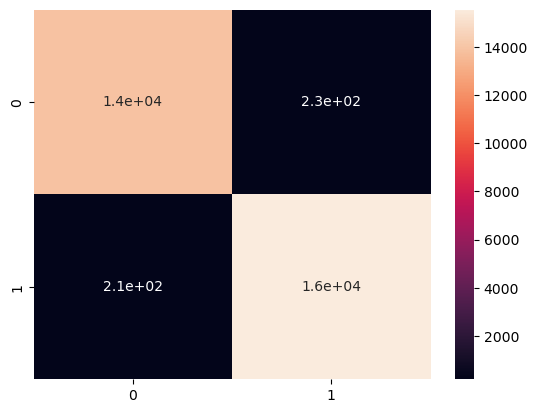

In [20]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [21]:
from keras.models import load_model
from pathlib import Path

model.save_weights("lstm_weights_LSTMModifiedDataset.h5")
print('done')

model.save('lstm_model_LSTMModifiedDataset.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
loaded_model = tf.keras.models.load_model('lstm_model_LSTMModifiedDataset.h5')
loaded_model.load_weights('lstm_weights_LSTMModifiedDataset.h5')

In [23]:
def clean_data(input_val):

    txts = tok.texts_to_sequences(input_val)
    input_val = sequence.pad_sequences(txts, maxlen=max_len)

    return input_val


def predict_sqli_attack():
    
    repeat=True
    
    space=''
    for i in range(20):
        space+= "-"

    print(space) 
    input_val=input("Please enter some data: ")
    print(space)

    
    if input_val== '0':
        repeat=False
    
    sample_texts_list = []
    sample_texts_list.append(input_val)
    txts = tok.texts_to_sequences(sample_texts_list)
    txts = sequence.pad_sequences(txts, maxlen=max_len)

    result=loaded_model.predict(txts)
    print(result)


    print(space)
    
    
    if repeat == True:
            if result > 0.5:
                 print("ALERT! This can be SQL injection")
            elif result <= 0.5:
                 print("It seems to be a benign")
            
            print(space)
        
            predict_sqli_attack()
            
    elif repeat == False:
        print( " Closing ")

In [24]:
predict_sqli_attack()

--------------------
Please enter some data: '
--------------------
1/1 [==============================] - 1s 803ms/step
[[0.8735781]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------
Please enter some data: "
--------------------
1/1 [==============================] - 0s 45ms/step
[[0.37421626]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: ~
--------------------
1/1 [==============================] - 0s 45ms/step
[[0.37421626]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: `
--------------------
1/1 [==============================] - 0s 45ms/step
[[0.37421626]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: ' '
--------------------
1/1 [==============================] - 0s 45ms/step
[[0.97706884]]
--------------------
ALERT! This can be SQL inject